In [9]:
# Handling ROOT files
import os, sys, json
import numpy as np, pandas as pd
import uproot, pickle
# Plotting
import matplotlib
from matplottery import Hist1D,Hist2D, plot_stack
import matplotlib.pyplot as plt
# Machine Learning
from sklearn.metrics import roc_curve
import xgboost as xgb # BDT
# Custom Tools
from data import GetData
from config import config
# Jupyter Display Settings
%matplotlib inline
pd.set_option('display.max_rows', 20)

In [10]:
# Get data
dataframes = GetData("outputs", verbose=True)
# Concatenate dataframes
data = pd.concat(dataframes.values())
# Drop rho or phi events
if config["analysis"] == "phi":
    data = data.drop(data.query("genHiggsMeson_id == 113").index)
elif config["analysis"] == "rho":
    data = data.drop(data.query("genKp_pt > 0").index)

Loaded Dataframes:
    TTJets_SingleLeptFromT
    TTGamma_SingleLeptFromTbar
    WGToLNuG
    TTJets_SingleLeptFromTbar
    WJetsToLNu
    WH_HtoRhoGammaPhiGamma
    TTGamma_SingleLeptFromT


In [11]:
# Get BDT model
bst = pickle.load(open("bdt.pkl", "r"))
# Get BDT features
with open ("features.json", "r") as fin:
    features = json.load(fin)

In [14]:
# Get BDT predictions
preds = bst.predict(xgb.DMatrix(data[features]))
# Define cuts
massCut = ((data.recoHiggs_mass > 115) & (data.recoHiggs_mass < 135))
phiMassCut = ((data.recoPhi_mass > 0.95) & (data.recoPhi_mass < 1.05))
dRCut = (data.recoKpKm_dR < 0.025)
ptCut = (data.recoKp_pt > 25)
isoCut = (data.recoPhi_iso < 3)
# Cut-based
cutBased = data[massCut & dRCut & ptCut & isoCut & phiMassCut]
# BDT
bdtBased = data[massCut & (preds > 0.9)]
# Get signal vs. background ratio
bdtRatio = float(len(bdtBased.query("signal == 1").index))/(len(bdtBased.query("signal == 0").index)**0.5)
cutRatio = float(len(cutBased.query("signal == 1").index))/(len(cutBased.query("signal == 0").index)**0.5)
print("Sig/sqrt(Bg) Ratio (BDT): {}".format(bdtRatio))
print("Sig/sqrt(Bg) Ratio (cut): {}".format(cutRatio))

Sig/sqrt(Bg) Ratio (BDT): 5781.28982274
Sig/sqrt(Bg) Ratio (cut): 3955.9687777


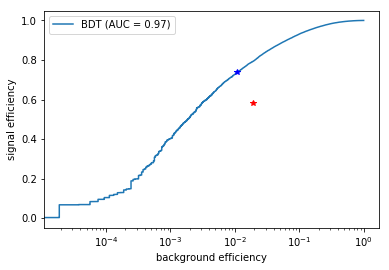

In [15]:
# BDT ROC Curve
fpr, tpr, thresh = roc_curve(data["signal"],preds)
bdtPoint = np.where(thresh > 0.9)[0][-1]
predFPR = fpr[bdtPoint]
predTPR = tpr[bdtPoint]
# Cut-based
cutsFPR = float(len(cutBased.query("signal == 0").index))/len(data.query("signal == 0 and @massCut").index)
cutsTPR = float(len(cutBased.query("signal == 1").index))/len(data.query("signal == 1 and @massCut").index)
# Plot
bins = np.linspace(0.,1.,30)
plt.semilogx(fpr, tpr, label="BDT (AUC = {:.2f})".format(np.trapz(tpr,fpr)));
plt.plot(predFPR,predTPR,"b*");
plt.plot(cutsFPR,cutsTPR,"r*");
# Settings
plt.xlabel("background efficiency");
plt.ylabel("signal efficiency");
plt.legend();